![image.png](https://i.imgur.com/a3uAqnb.png)

#🌦️ **Neural Networks for Tabular Data: Weather Type Classification**
---



In this lab, we will:
- Classify **weather types** using a neural network built with PyTorch
- Build a **Four-layer multiclass neural network classifier**
- Train the model on tabular weather data
- Evaluate the model’s performance on unseen data




In [ ]:
import kagglehub
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

##📊 **About The Dataset**

This is a **synthetic weather dataset** designed for **multiclass classification**.  
It contains numerical and categorical weather-related features such as **temperature, humidity, wind speed, precipitation, cloud cover, pressure, UV index, season, visibility, and location**.

The **target variable** is **Weather Type**, which classifies each sample into one of four classes: **Rainy, Sunny, Cloudy, or Snowy**.

Dataset link: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data

### 🔹**Read Data**


In [ ]:
# Download latest version
path = kagglehub.dataset_download("nikhil7280/weather-type-classification")

print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/weather_classification_data.csv")
df.head()

Using Colab cache for faster access to the 'weather-type-classification' dataset.
Path to dataset files: /kaggle/input/weather-type-classification


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [ ]:
# Check data types and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


### 🔹**Prepare Data**


> Before training the model, we'll prepare the data by **encoding categorical features and the target variable**, and **scaling numerical features** to ensure stable and efficient neural network training.





In [ ]:
# Import LabelEncoder if not already imported in a previous cell
from sklearn.preprocessing import LabelEncoder

# Isolate the target variable 'Weather Type' and apply Label Encoding to it
le = LabelEncoder()
df['Weather Type'] = le.fit_transform(df['Weather Type'])

# Identify remaining categorical columns (features)
categorical_features = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding to these categorical features using pd.get_dummies
df = pd.get_dummies(df, columns=categorical_features, drop_first=False)

df = df.astype(float)


# Display the updated DataFrame
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Weather Type,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14.0,73.0,9.5,82.0,1010.82,2.0,3.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,39.0,96.0,8.5,71.0,1011.43,7.0,10.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,30.0,64.0,7.0,16.0,1018.72,5.0,5.5,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,38.0,83.0,1.5,82.0,1026.25,7.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,27.0,74.0,17.0,66.0,990.67,1.0,2.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74.0,14.5,71.0,1003.15,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13196,-1.0,76.0,3.5,23.0,1067.23,1.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
13197,30.0,77.0,5.5,28.0,1012.69,3.0,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13198,3.0,76.0,10.0,94.0,984.27,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# Standardize features using StandardScaler
# Explicitly select only the original numerical columns for scaling
numerical_cols = [
    'Temperature',
    'Humidity',
    'Wind Speed',
    'Precipitation (%)',
    'Atmospheric Pressure',
    'UV Index',
    'Visibility (km)'
]

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Weather Type,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,-0.294931,0.212404,-0.048086,0.887629,0.134203,-0.520104,-0.582231,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.143035,1.351385,-0.192836,0.543291,0.150602,0.776424,1.345768,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.625367,-0.233285,-0.409962,-1.178401,0.346579,0.257813,0.010999,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.085516,0.707613,-1.206089,0.887629,0.549008,0.776424,-1.323769,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.452811,0.261924,1.037543,0.386773,-0.407490,-0.779410,-0.878846,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,-0.525006,0.261924,0.675666,0.543291,-0.071990,-0.779410,-1.323769,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13196,-1.157711,0.360966,-0.916588,-0.959276,1.650675,-0.779410,0.159307,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
13197,0.625367,0.410487,-0.627087,-0.802759,0.184474,-0.260799,1.049153,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13198,-0.927636,0.360966,0.024290,1.263271,-0.579542,-1.038715,-1.027154,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0




> After preprocessing data, we'll first split the dataset into features and target labels, apply a train–test split, and then convert the data into PyTorch tensors




In [ ]:
# split features from targets
X = df.drop("Weather Type",axis=1)
y = df['Weather Type']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# transform to tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test  = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test  = torch.tensor(y_test.values, dtype=torch.long)



> After converting the data into tensors, we group features and labels into **TensorDataset** objects.  
We then use **DataLoaders** to load the data in mini-batches for efficient training and evaluation.





In [ ]:
# Create TensorDatasets for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create Dataloaders to train and test data in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print("Train dataset:", len(train_dataset))
print("Test dataset:", len(test_dataset))

# Get the first batch from the training DataLoader
X_batch, y_batch = next(iter(train_loader))
print(f"Training batch input shape: {X_batch.shape}")
print(f"Training batch labels shape: {y_batch.shape}")

Train dataset: 10560
Test dataset: 2640
Training batch input shape: torch.Size([32, 18])
Training batch labels shape: torch.Size([32])


> Data now is ready for the model ! Lets build the model class.
---

### 🔹**Model Class**


Let’s create the **architecture of our model** by implementing a **four-layer neural network classifier**.

The model consists of multiple hidden layers with non-linear activations, followed by an output layer for multiclass prediction.  
Instead of **sigmoid**, we use **softmax** at the output layer:
- **Sigmoid** outputs values independently in the range (0, 1)
- **Softmax** converts a vector of scores into class probabilities that sum to 1

Softmax formula:  
$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$


In [ ]:
class NN4Layer(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN4Layer, self).__init__()

        # First linear layer: input features -> hidden layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)

        # Second linear layer: hidden layer -> hidden layer
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)

        # Third linear layer: hidden layer -> hidden layer
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)

        # Output layer: hidden layer -> number of classes (logits)
        self.layer4 = nn.Linear(hidden_dim, output_dim)

        # ReLU activation for non-linearity
        self.relu = nn.ReLU()

    # Defines how input data flows through the network
    def forward(self, x):
        # First hidden layer
        a1 = self.relu(self.layer1(x))

        # Second hidden layer
        a2 = self.relu(self.layer2(a1))

        # Third hidden layer
        a3 = self.relu(self.layer3(a2))

        # Output layer (raw scores / logits)
        output = self.layer4(a3)  # we said we'll use softmax, where is it? ¯\(ツ)/¯

        return output


📌 **Note on Softmax**

The output of this model consists of **raw scores (logits)**, not probabilities.  
When using `CrossEntropyLoss`, **Softmax is applied internally**, so it should **not** be included in the model’s architecture.

Softmax can be applied **only during evaluation** if class probabilities are needed.

---

### 🔹**Training Loop**

In [ ]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    # Set the model to training mode
    model.train()

    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move batch to the selected device
        X_batch = X_batch.to(device)         # shape: (batch_size, num_features)
        y_batch = y_batch.to(device)         # shape: (batch_size,)

        # Forward pass (outputs are logits)
        outputs = model(X_batch)             # shape: (batch_size, num_classes)
        loss = criterion(outputs, y_batch)

        # Backward pass & optimization
        optimizer.zero_grad()   # Clear previous gradients
        loss.backward()         # Compute gradients
        optimizer.step()        # Update model parameters

        running_loss += loss.item()

    # Average loss over all batches
    avg_loss = running_loss / len(train_loader)

    return avg_loss


### 🔹**Validation Loop**

In [ ]:
def validate(model, criterion, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to device
            X_batch = X_batch.to(device)     # shape: (batch_size, num_features)
            y_batch = y_batch.to(device)     # shape: (batch_size,)

            # Forward pass
            outputs = model(X_batch)         # shape: (batch_size, num_classes)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

            # Apply Softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Pick the classes with highest probabilities
            predicted = torch.argmax(probabilities, dim=1)

            # Accuracy calculation
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy

---

### 🔹**Running Training**

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
input_dim = X_train.shape[1]   # Number of tabular features
hidden_dim = 14                # Design choice
output_dim = 4                 # Weather classes: Rainy, Sunny, Cloudy, Snowy

# Instantiate model
model = NN4Layer(input_dim, hidden_dim, output_dim).to(device)

# Print the model architecture
print("Model Architecture:\n")
print(model)

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")


Model Architecture:

NN4Layer(
  (layer1): Linear(in_features=18, out_features=14, bias=True)
  (layer2): Linear(in_features=14, out_features=14, bias=True)
  (layer3): Linear(in_features=14, out_features=14, bias=True)
  (layer4): Linear(in_features=14, out_features=4, bias=True)
  (relu): ReLU()
)

Total trainable parameters: 746


In [ ]:
num_epochs = 20
learning_rate = 0.001

# Define criterion (loss function) - using CrossEntropyLoss as model now outputs logits
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = AdamW(model.parameters(), learning_rate)

In [ ]:
# Run Training
train_losses = []
val_losses = []
val_accuracies = []

print('Starting Training...')
for epoch in range(num_epochs):
    # Train one epoch
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)

    # Validate
    val_loss, val_accuracy = validate(model, criterion, test_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print('Training Complete!')

Starting Training...
Epoch [1/20], Train Loss: 0.8324, Val Loss: 0.4586, Val Accuracy: 0.8667
Epoch [2/20], Train Loss: 0.3717, Val Loss: 0.3483, Val Accuracy: 0.8841
Epoch [3/20], Train Loss: 0.3091, Val Loss: 0.3040, Val Accuracy: 0.8936
Epoch [4/20], Train Loss: 0.2790, Val Loss: 0.2803, Val Accuracy: 0.8962
Epoch [5/20], Train Loss: 0.2575, Val Loss: 0.2585, Val Accuracy: 0.8977
Epoch [6/20], Train Loss: 0.2411, Val Loss: 0.2453, Val Accuracy: 0.9011
Epoch [7/20], Train Loss: 0.2306, Val Loss: 0.2382, Val Accuracy: 0.9008
Epoch [8/20], Train Loss: 0.2220, Val Loss: 0.2333, Val Accuracy: 0.9038
Epoch [9/20], Train Loss: 0.2168, Val Loss: 0.2310, Val Accuracy: 0.9011
Epoch [10/20], Train Loss: 0.2124, Val Loss: 0.2293, Val Accuracy: 0.9019
Epoch [11/20], Train Loss: 0.2087, Val Loss: 0.2266, Val Accuracy: 0.9038
Epoch [12/20], Train Loss: 0.2053, Val Loss: 0.2282, Val Accuracy: 0.8996
Epoch [13/20], Train Loss: 0.2039, Val Loss: 0.2239, Val Accuracy: 0.9023
Epoch [14/20], Train Loss:

> Lets see what train and validation losses look like

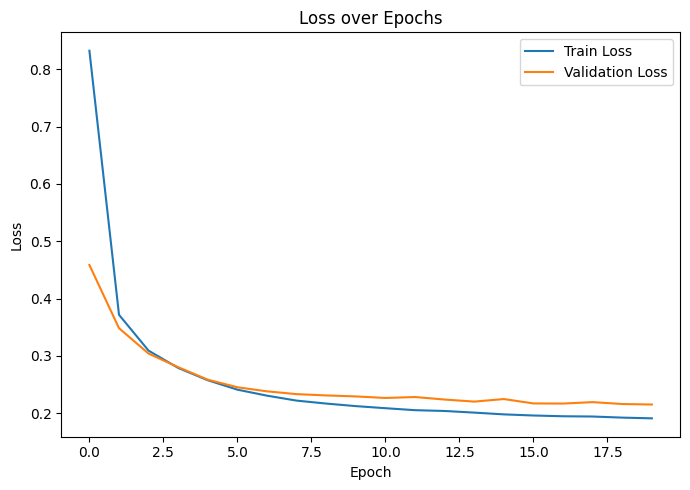

In [ ]:
# Plotting results
plt.figure(figsize=(7, 5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9064


In [ ]:
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[584  49   3  24]
 [ 35 606   6  13]
 [ 22  20 596  22]
 [ 29  21   3 607]]


After running the model with five different seeds and averaging the results, one-hot encoding did perform slightly better than label encoding. The improvement is small, but at least now we know we’re doing the right thing :D

### 💾 **Saving the Model**

After training, we can save the model so it can be **reused later without retraining**.  
In PyTorch, the recommended approach is to save the model’s **state dictionary**, which contains all learned parameters.

In [ ]:
# Save the trained model parameters
torch.save(model.state_dict(), "weather_nn4layer.pth")

print("Model saved successfully!")

Model saved successfully!


> if you want to use the model :


In [ ]:
# Recreate the model architecture
model = NN4Layer(input_dim, hidden_dim, output_dim)
# Load saved parameters
model.load_state_dict(torch.load("weather_nn4layer.pth"))
# Set model to evaluation mode
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


## We're done!
try to play with hyperparameters and evaluate the results :)

<a href="https://imgflip.com/i/ags9pe"><img src="https://i.imgflip.com/ags9pe.jpg" width="30%"/>

### **Contributed by: Yara Alzahrani**
Extra Notes made by: Boushra Almazroua
